# Pet and Breed Category prediction

In [1]:
import math
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

from catboost import CatBoostClassifier

In [2]:
train_df = pd.read_csv('data/train.csv', parse_dates=['issue_date','listing_date'])
test_df = pd.read_csv('data/test.csv', parse_dates=['issue_date', 'listing_date'])

## Preprocessing

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18834 entries, 0 to 18833
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   pet_id          18834 non-null  object        
 1   issue_date      18834 non-null  datetime64[ns]
 2   listing_date    18834 non-null  datetime64[ns]
 3   condition       17357 non-null  float64       
 4   color_type      18834 non-null  object        
 5   length(m)       18834 non-null  float64       
 6   height(cm)      18834 non-null  float64       
 7   X1              18834 non-null  int64         
 8   X2              18834 non-null  int64         
 9   breed_category  18834 non-null  float64       
 10  pet_category    18834 non-null  int64         
dtypes: datetime64[ns](2), float64(4), int64(3), object(2)
memory usage: 1.6+ MB


### Finding missing values

In [4]:
train_df.isna().sum()

pet_id               0
issue_date           0
listing_date         0
condition         1477
color_type           0
length(m)            0
height(cm)           0
X1                   0
X2                   0
breed_category       0
pet_category         0
dtype: int64

Text(0.5, 0.98, 'Missing values in conditions vs response variables')

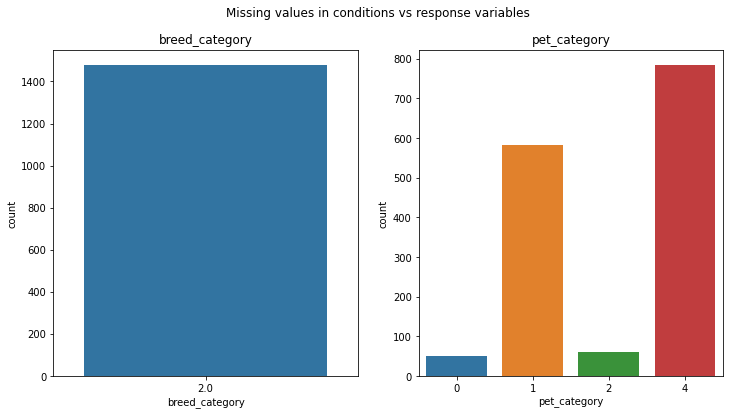

In [5]:
response_vars = ['breed_category','pet_category']

n = len(response_vars)
nrows = math.ceil(n/2)
ncols = 2

fig, ax = plt.subplots(nrows, ncols, sharex='col', figsize=(12, 6))

for index, value in enumerate(response_vars):
    sns.countplot(data=train_df[train_df['condition'].isna()][[value]], 
                  x=value, 
                  ax=ax[index])
    ax[index].set_title(value)
plt.suptitle("Missing values in conditions vs response variables")

In [6]:
def sns_cnt_plot(var):
    sns.set(rc={'figure.figsize':(12,5), 'figure.dpi':100})
    sns.countplot(data=train_df[train_df['condition'].isna()][[var]], 
                  x=var, palette=sns.color_palette('coolwarm', 6))
    plt.xticks(rotation=45)
    plt.title(f'{var} count plot for missing condition values')
    plt.show()

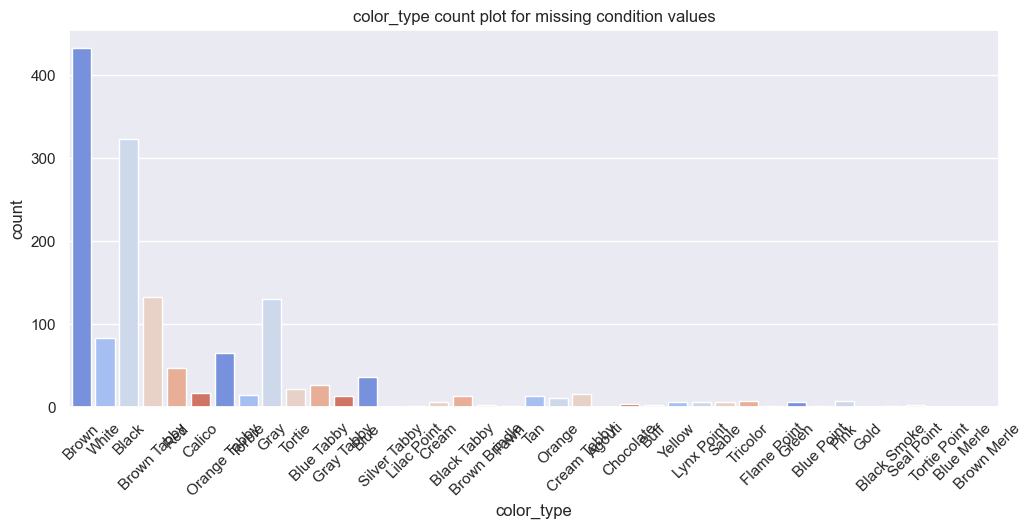

In [7]:
sns_cnt_plot('color_type')

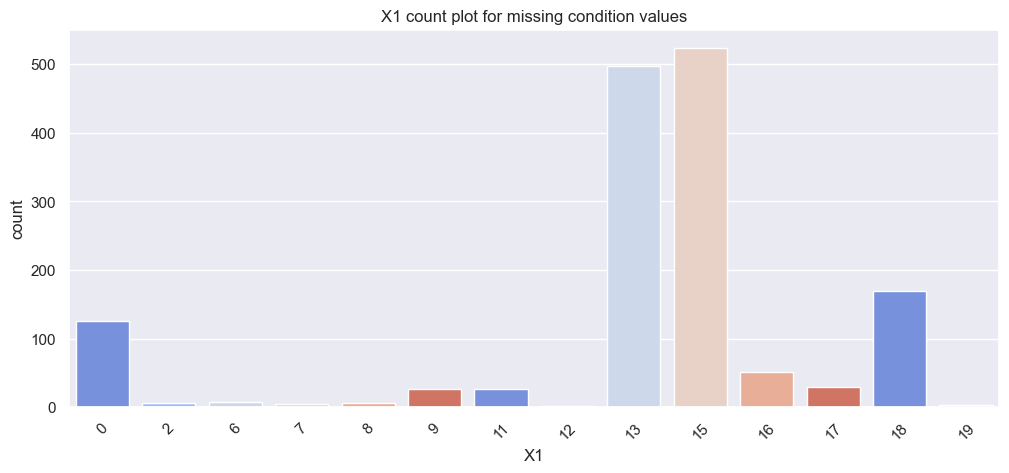

In [8]:
sns_cnt_plot('X1')

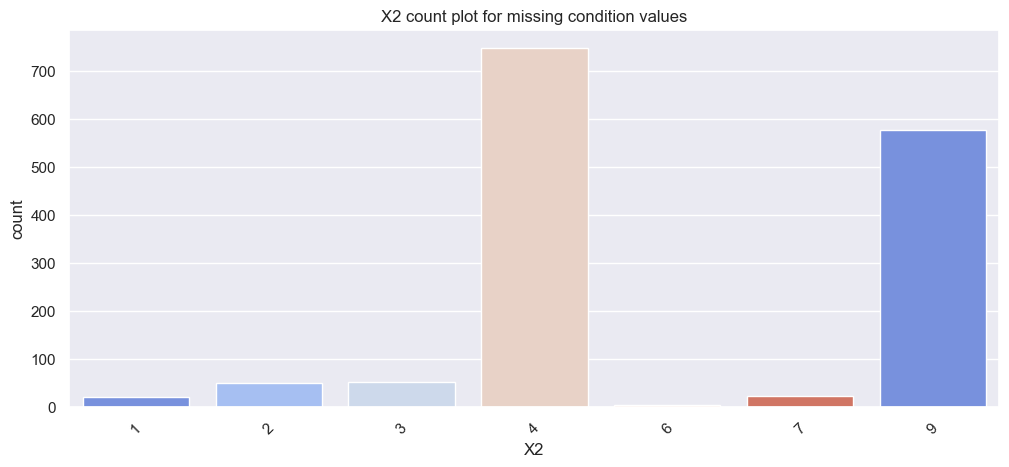

In [9]:
sns_cnt_plot('X2')

In [10]:
def sns_dist_plot(var):
    sns.set(rc={'figure.figsize':(12,5), 'figure.dpi':100})
    sns.distplot(train_df[train_df['condition'].isna()][[var]])
    plt.xticks(rotation=45)
    plt.title(f'{var} dist plot for missing condition values')
    plt.show()

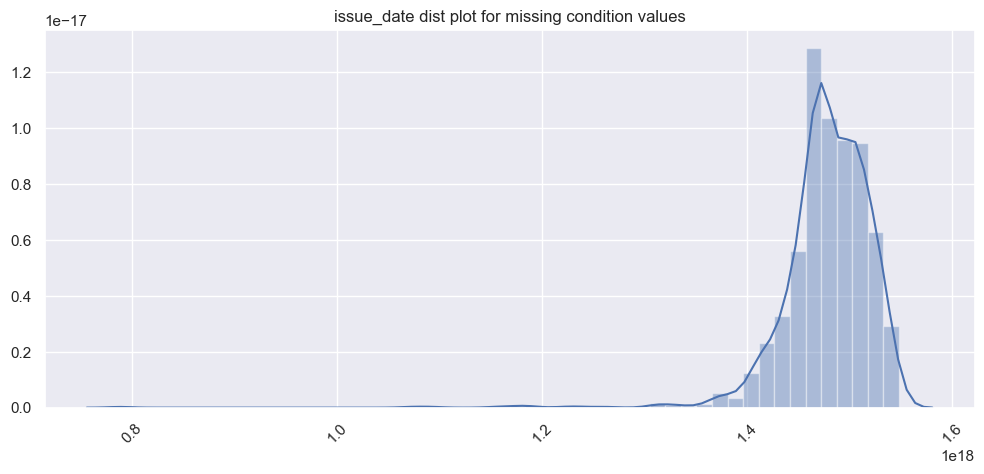

In [11]:
sns_dist_plot('issue_date')

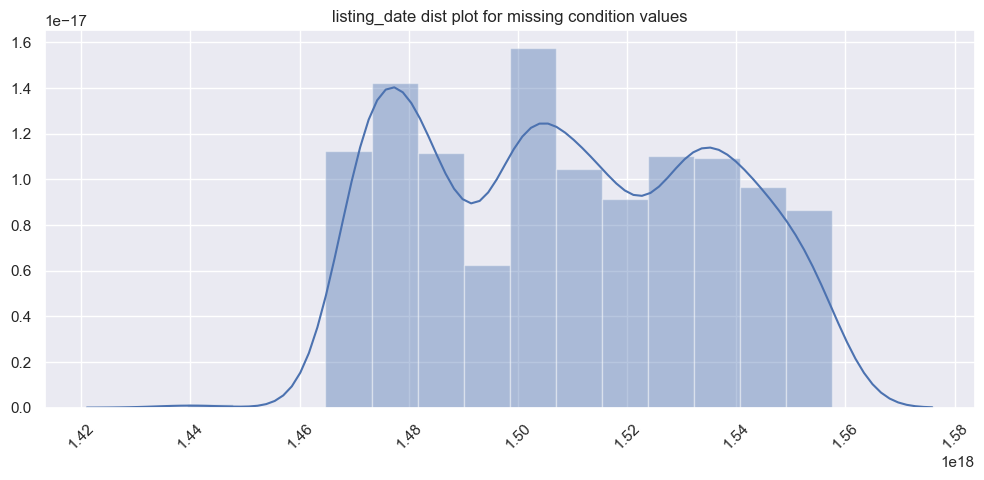

In [12]:
sns_dist_plot('listing_date')

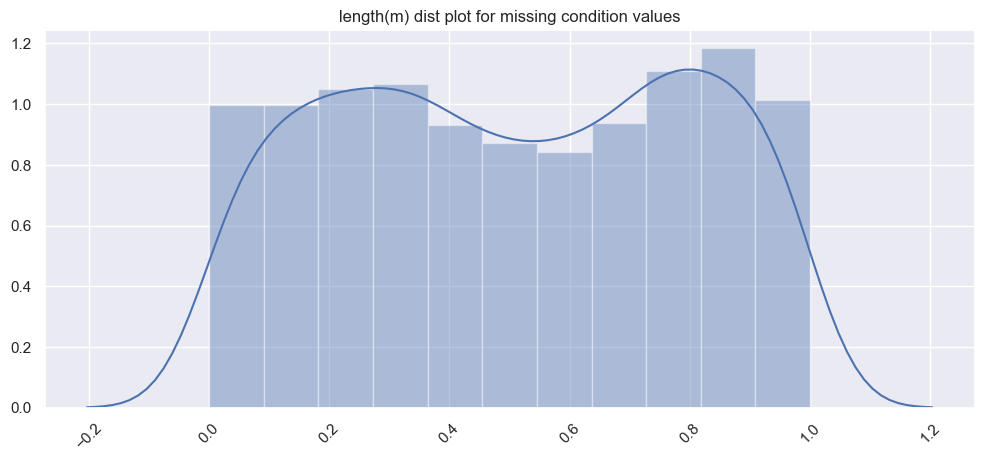

In [13]:
sns_dist_plot('length(m)')

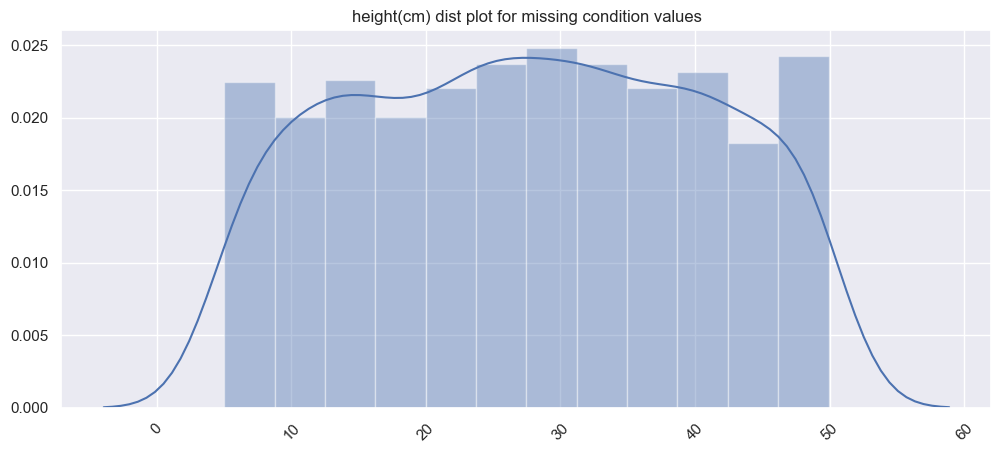

In [14]:
sns_dist_plot('height(cm)')

### Variable Mutation & Encoding

Calculating date difference

In [15]:
train_df['date_diff(days)'] = train_df['listing_date'] - train_df['issue_date']
train_df['date_diff(days)'] = train_df['date_diff(days)']/datetime.timedelta(days=1)

test_df['date_diff(days)'] = test_df['listing_date'] - test_df['issue_date']
test_df['date_diff(days)'] = test_df['date_diff(days)']/datetime.timedelta(days=1)

* Separating `issue_date` into its year, month and day
* If this doesn't work, change it to epoch

In [16]:
train_df['issue_year'] = train_df['issue_date'].dt.year
train_df['issue_month'] = train_df['issue_date'].dt.month
train_df['issue_day'] = train_df['issue_date'].dt.day

test_df['issue_year'] = test_df['issue_date'].dt.year
test_df['issue_month'] = test_df['issue_date'].dt.month
test_df['issue_day'] = test_df['issue_date'].dt.day

Dropping unnecessary columns

In [17]:
train_df.drop(['issue_date', 'listing_date'], axis=1, inplace=True)
test_df.drop(['issue_date', 'listing_date'], axis=1, inplace=True)

Encoding

In [18]:
enc = OneHotEncoder(handle_unknown = 'ignore')
enc.fit(train_df[['color_type']])

train_ohe_df = pd.DataFrame(enc.transform(train_df[['color_type']]).toarray(), columns=enc.get_feature_names())
test_ohe_df = pd.DataFrame(enc.transform(test_df[['color_type']]).toarray(), columns=enc.get_feature_names())

train_df.drop(['color_type'], axis=1, inplace=True)
test_df.drop(['color_type'], axis=1, inplace=True)

train_df = train_df.join(train_ohe_df)
test_df = test_df.join(train_ohe_df)

### Filling Missing Values

In [19]:
train_cond, validate_cond = train_test_split(train_df.dropna(subset=['condition']), test_size=0.2, random_state=1234)

#### Using Random Forest Regressor

In [20]:
rfmodel_condition = RandomForestClassifier(n_estimators=1000,
                                           max_depth=100, 
                                           max_features='log2')
rfmodel_condition.fit(X=train_cond.drop(['pet_id','condition', 'pet_category', 'breed_category'], axis=1),
                      y=train_cond[['condition']])

<ipython-input-20-04ab8d69fbfc>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfmodel_condition.fit(X=train_cond.drop(['pet_id','condition', 'pet_category', 'breed_category'], axis=1),


RandomForestClassifier(max_depth=100, max_features='log2', n_estimators=1000)

In [21]:
train_cond_y_hat = rfmodel_condition.predict(train_cond.drop(['pet_id','condition', 'pet_category', 'breed_category'],
                                                             axis=1))
print(accuracy_score(train_cond_y_hat, train_cond['condition']))
print(classification_report(train_cond_y_hat, train_cond['condition']))

1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      5019
         1.0       1.00      1.00      1.00      5458
         2.0       1.00      1.00      1.00      3408

    accuracy                           1.00     13885
   macro avg       1.00      1.00      1.00     13885
weighted avg       1.00      1.00      1.00     13885



In [22]:
validate_cond_y_hat = rfmodel_condition\
.predict(X=validate_cond.drop(['pet_id','condition','pet_category', 'breed_category'], axis=1))
print(accuracy_score(validate_cond_y_hat, validate_cond['condition']))
print(classification_report(validate_cond_y_hat, validate_cond['condition']))

0.548963133640553
              precision    recall  f1-score   support

         0.0       0.41      0.52      0.46      1002
         1.0       0.61      0.50      0.55      1659
         2.0       0.65      0.68      0.66       811

    accuracy                           0.55      3472
   macro avg       0.56      0.57      0.56      3472
weighted avg       0.56      0.55      0.55      3472



#### Using CatBoostClassifier

In [23]:
catmodel_condition = CatBoostClassifier(max_depth=4, 
                                        learning_rate=0.06900,
                                        n_estimators=3000,
                                        eval_metric='Accuracy',
                                        random_seed=2405, 
                                        use_best_model=True,
                                        silent=True,
                                        random_strength=1.0944250924022183,
                                        reg_lambda=1.2762795426592872)

catmodel_condition.fit(X=train_cond.drop(['pet_id','condition', 'pet_category', 'breed_category'], axis=1),
                       y=train_cond[['condition']], 
                       eval_set=(validate_cond.drop(['pet_id','condition','pet_category', 'breed_category'], axis=1), 
                                 validate_cond['condition']), 
                       plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Filling NA values with catboostclassifier's output

In [24]:
train_df.loc[train_df.condition.isna(), 'condition'] = \
catmodel_condition.predict(train_df[train_df.condition.isna()]\
                           .drop(['pet_id', 'condition', 'pet_category', 'breed_category'], axis=1))

In [25]:
test_df.loc[test_df.condition.isna(), 'condition'] = \
catmodel_condition.predict(test_df[test_df.condition.isna()]\
                           .drop(['pet_id', 'condition'], axis=1))

In [26]:
train_df.isna().sum().sum()

0

In [27]:
test_df.isna().sum().sum()

0

## Prediction

### `Breed_Category`

#### Splitting

In [28]:
train_breed_X, validate_breed_X, train_breed_y, validate_breed_y = \
train_test_split(train_df.drop(['pet_category','breed_category','pet_id'], axis=1),
                 train_df[['breed_category']],
                 test_size=0.3, 
                 stratify=train_df['breed_category'], random_state=1234)

#### Training

In [29]:
catmodel_breed_clf = CatBoostClassifier(iterations=10000, depth=5, 
                                        learning_rate=0.063,
                                        use_best_model=True, silent=True,
                                        eval_metric='Accuracy',
                                        random_strength=1.58713,
                                        reg_lambda=1.00314, random_seed=2504)

catmodel_breed_clf.fit(X=train_breed_X,
                       y=train_breed_y, 
                       eval_set=(validate_breed_X, validate_breed_y), 
                       plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

#### Test predictions

In [30]:
test_df['breed_category'] = catmodel_breed_clf.predict(test_df.drop(['pet_id'], axis=1))

### `Pet_category`

#### Splitting

In [31]:
train_pet_X, validate_pet_X, train_pet_y, validate_pet_y = \
train_test_split(train_df.drop(['pet_category','pet_id'], axis=1),
                 train_df[['pet_category']],
                 test_size=0.3, 
                 stratify=train_df['pet_category'], random_state=1234)

#### Training

In [32]:
catmodel_pet_clf = CatBoostClassifier(iterations=10000, depth=3, 
                                        learning_rate=0.069,
                                        use_best_model=True, silent=True,
                                        eval_metric='Accuracy',
                                        random_strength=1.58713,
                                        reg_lambda=1.00314, random_seed=2504)

catmodel_pet_clf.fit(X=train_pet_X,
                     y=train_pet_y, 
                     eval_set=(validate_pet_X, validate_pet_y), 
                     plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

#### Test Predictions

In [33]:
test_df['pet_category'] = catmodel_breed_clf.predict(test_df.drop(['pet_id'], axis=1))

## Saving Output

In [37]:
test_final[['pet_id', 'breed_category', 'pet_category']].to_csv('output/output.csv', index=False)